# Numerically Solving the Schrodinger Equation for the Quantum Harmonic Oscillator
We consider solutions of the time independent Schrodinger equation for the quantum harmonic oscillator with:
$$-\frac{\hbar^2}{2m}\frac{d^2\psi}{dx^2}+V(x)\psi(x)=E\psi(x)$$
We will make use of Numerov's method for solving second order ODEs.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## Building Numerical and Analytic $\psi(x)$ Functions
We choose units so the TISE becomes:
$$\frac{d^2\psi}{dx^2}=f(x)\psi$$
where we have $f(x)=V(x)-E$ and $V(x)=x^2$. We solve on the interval $[x_0, x_1]$ in steps of size $\delta$.

\\
We deal with the boundary conditions:
$$\psi(0)=\begin{cases} 0 \text{ for odd } n\\ 1 \text{ for even } n\end{cases}$$
$$\psi'(0)=\begin{cases} 1 \text{ for odd } n\\ 0 \text{ for even } n\end{cases}$$
The numerical approximator uses Numerov's method:
$$\left[1-\frac{\delta^2}{12}f\left([j+1]\delta\right)\right]\psi([j+1]\delta)=\left[2+\frac{5\delta^2}{6}f(j\delta)\right]\psi(j\delta)-\left[1-\frac{\delta^2}{12}f([j-1]\delta)\right]\psi([j-1]\delta)$$

This evidently requires two adjacent points to find the rest, but our boundary conditions only provide one, $\psi(0)$. We can find $\psi(\delta)$ using:
$$\psi(\delta) = \psi(0)+\frac{\delta^2}{2}f(0)\psi(0)+\frac{\delta^4}{24}\left(f''(0)\psi(0)+2f'(0)\psi'(0)+f(0)^2\psi(0)\right) \text{ for even } n$$
$$\psi(\delta)=\delta\psi'(0)+\frac{\delta^3}{6}\left(f(0)\psi'(0)+f'(0)\psi(0)\right) \text{ for odd } n$$

Note that for harmonic oscillators we have $f'(0)=0$
\\
After finding the second point using either of these methods, we just run the Numerov method repeatedly to find the rest of the points.


Note that the analytical solutions take the form:
$$\psi_n(x)=H_n(x)e^{-x^2/2}$$
where $H_n$ are the Hermite polynomials.

In [ ]:
x0 = 0
x1 = 5
delta = 0.05
num_points = int(1+(x1-x0)/0.05)
x = np.linspace(x0,x1,num=num_points)

In [ ]:
def f(x,E):
  return x**2-E

In [ ]:
# This will output a numerical approximation of psi(x) given the function and boundary conditions @x=0
def solve_numerov(f, x, n, E):
  psi = np.zeros_like(x)
  if n%2 == 0:
    psi0 = 1
    dpsi0 = 0
    psi[0] = psi0
    psi[1] = psi0 + 0.5*delta**2*f(0,E)*psi0+(1/24)*delta**4*(f(0,E)*psi0+f(0,E)**2*psi0)
  else:
    psi0 = 0
    dpsi0 = 1
    psi[0] = psi0
    psi[1] = delta*dpsi0+(1/6)*delta**3*(f(0,E)*dpsi0)
  for i in range(num_points-2):
    a = 1-f(x[i+2],E)*delta**2/12
    b = 2+delta**2*f(x[i+1],E)*5/6
    c = 1-delta**2*f(x[i],E)/12
    psi[i+2]= (b*psi[i+1]-c*psi[i])/a
  return psi

In [ ]:
# This will output a set of psi values which have been computed analytically
from numpy.polynomial.hermite import Hermite

def analytic_psi(n,x):
  # Generate correct form of nth state wave function
  coeffs = np.zeros(n+1)
  coeffs[n] = 1
  poly = Hermite(coeffs)
  # Generate the psi values
  func = lambda x: poly(x) * np.exp(-x**2/2)
  psi = func(x)
  # For odd n we require dpsi0 = 1 and for even n we require psi0=1 so need to divide by gradient or true value at 0 to make 1.
  if n % 2 == 0:
    div = func(0)
  else:
    h=0.000001
    div = (func(h)-func(0))/h
  return psi/div

## Investigating the Ground State
Ground state has $n=0$. Energies should satisfy $E_n=2n+1$ so we should have $E_n=1$. We'll also check the behaviour for $E_n=1\pm 0.05$.

(0.0, 5.0)

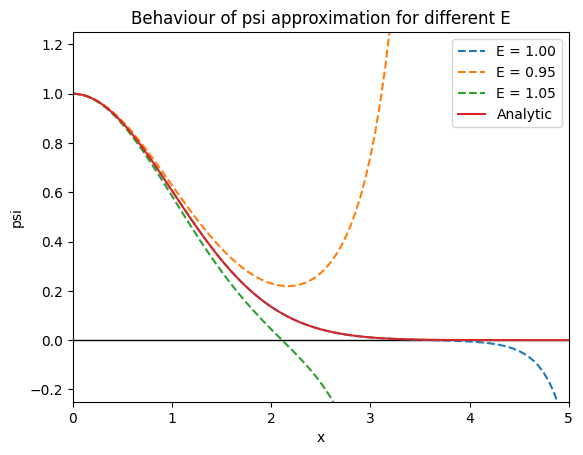

In [ ]:
n = 0
plt.plot(x,np.zeros(x.shape),linewidth=1, c='black')
plt.plot(x,solve_numerov(f,x,n,1.00), '--', label="E = 1.00")
plt.plot(x,solve_numerov(f,x,n,0.95), '--', label="E = 0.95")
plt.plot(x,solve_numerov(f,x,n,1.05), '--', label="E = 1.05")
plt.plot(x,analytic_psi(n,x), label="Analytic")
plt.legend()
y = np.pi**(0)*np.exp(-x**2/2)
plt.title("Behaviour of psi approximation for different E")
plt.xlabel("x")
plt.ylabel("psi")
plt.ylim(-0.25,1.25)
plt.xlim(0,5)

The approximation clearly diverges quickly for $E\not = 0$

## Higher Order States

Text(0.5, 1.0, 'n = 7 wave function approximation')

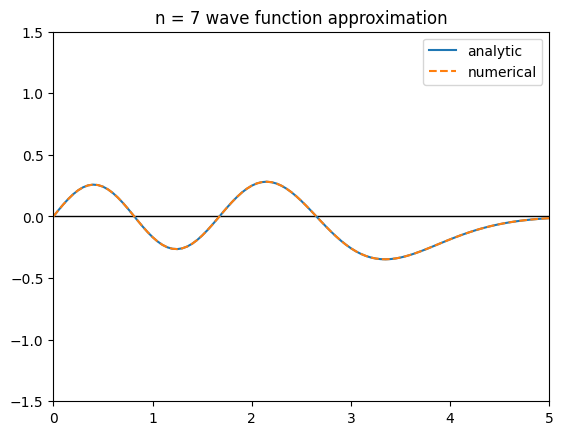

In [ ]:
n = 7
E = 2*n + 1
y = analytic_psi(n, x)
psi = solve_numerov(f,x,n,E)
plt.plot(x,np.zeros(x.shape),linewidth=1, c='black')
plt.plot(x,y,label='analytic')
plt.plot(x,psi,'--',label='numerical')
plt.legend()
plt.ylim(-1.5,1.5)
plt.xlim(x0,x1)
plt.title(f"n = {n} wave function approximation")

## Finding Energy Eigenvalues using the Analytic Solution
We employ the strategy of minimising a function proportional to the mean square error:
$$L(E) = \int_{x_0}^{x_1}[\psi_a(x)-\psi_n(x,E)]^2dx$$
Gradient descent can be used to update the parameters, until a minimum of $L$ can be found. We iteratively update $L$ through:
$$E_{i+1}=E_i-\alpha\frac{\partial L}{\partial E}\Big|_{i}$$
where $\alpha$ is called the learning rate. We find the gradient with:
$$\frac{\partial L}{\partial E}=\frac{L(E+h)-L(E)}{h}$$
where $h \ll 1$.
Due to the extreme divergence of the approximation for large $x$, we observe behaviour where $\partial_E L \gg E$. This causes the optimiser to diverge. A way to prevent this is by using a very small learning rate. This causes it to converge but very slowly. In order to solve this problem, we scale the loss function by a factor of $[\text{max}(\psi_a(x)-\psi_n(x,E_0))]^{-1}$. This maps the domain of $L$ onto the same order as $E$.

In [ ]:
def MSE(f1,f2,norm_factor):
  scaled_res = (f1-f2)/norm_factor
  return np.sum((scaled_res)**2)/num_points
h = 0.000001
n = 2
E = 5.3
alpha = 0.1
norm_factor = np.max(np.abs((analytic_psi(n, x)-solve_numerov(f,x, n, E))))
def grad_loss(analytic_psi, solve_numerov, n, x, f, E, h):
  #print(f"norm_factor: {norm_factor}")
  return (MSE(analytic_psi(n, x), solve_numerov(f,x, n, E+h), norm_factor)-MSE(analytic_psi(n, x), solve_numerov(f,x, n, E), norm_factor))/h
for i in range(50):
  dLdE = grad_loss(analytic_psi, solve_numerov, n, x, f, E, h)
  #print(f"dLdE = {dLdE}")
  E = E - alpha * dLdE
  print(f"epoch {i}: E = {E}")

epoch 0: E = 5.284622454428373
epoch 1: E = 5.269504903533923
epoch 2: E = 5.2546863118642095
epoch 3: E = 5.240204290662867
epoch 4: E = 5.2260945508394725
epoch 5: E = 5.212390382766566
epoch 6: E = 5.199122167002635
epoch 7: E = 5.186316943413337
epoch 8: E = 5.173998044403605
epoch 9: E = 5.162184814860069
epoch 10: E = 5.150892418769462
epoch 11: E = 5.140131743057345
epoch 12: E = 5.129909397940433
epoch 13: E = 5.120227810505557
epoch 14: E = 5.1110854020556475
epoch 15: E = 5.1024768413910735
epoch 16: E = 5.094393359203986
epoch 17: E = 5.0868231102874075
epoch 18: E = 5.079751566022102
epoch 19: E = 5.073161926677322
epoch 20: E = 5.067035535427678
epoch 21: E = 5.061352283495245
epoch 22: E = 5.056090998857816
epoch 23: E = 5.05122980613953
epoch 24: E = 5.046746455004656
epoch 25: E = 5.0426186118900915
epoch 26: E = 5.0388241146310575
epoch 27: E = 5.035341187533003
epoch 28: E = 5.03214862066123
epoch 29: E = 5.029225912660335
epoch 30: E = 5.026553382047165
epoch 31: E =

## Finding Energy Eigenvalues Without the Analytic Solution
Observe from the first section that our approximations rapidly diverge at $x_1$ for values $E\not = 2n+1$. We can attempt to use this idea to determine $E$ by minimising $|\psi(x_1)|$. We can again use gradient descent, except this time our loss function will simply be:
$$L(E) = [\psi_n(x_1, E)]^2$$

In [ ]:
h = 0.000001
n = 6
E = 12.95
alpha = 0.0001
norm_factor = solve_numerov(f, x, n, E)[-1]
print(f"norm_factor = {norm_factor}")
for i in range(50):
  loss = lambda x: x**2
  dLdE = (loss(solve_numerov(f,x,n, E+h)[-1]/norm_factor)-loss(solve_numerov(f,x,n, E)[-1]/norm_factor))/h
  #print(f"dLdE = {dLdE}")
  E = E - alpha * dLdE
  print(f"epoch {i}: E = {E}")

norm_factor = -0.9647767296865819
epoch 0: E = 12.953983863113132
epoch 1: E = 12.957641369235445
epoch 2: E = 12.961001669995824
epoch 3: E = 12.964090951033196
epoch 4: E = 12.966932787624879
epoch 5: E = 12.96954844908853
epoch 6: E = 12.97195716213128
epoch 7: E = 12.97417633800681
epoch 8: E = 12.976221770708346
epoch 9: E = 12.978107809008508
epoch 10: E = 12.979847507525431
epoch 11: E = 12.981452759311935
epoch 12: E = 12.982934412414677
epoch 13: E = 12.984302373169102
epoch 14: E = 12.985565697407603
epoch 15: E = 12.986732671544921
epoch 16: E = 12.987810884967397
epoch 17: E = 12.988807294504547
epoch 18: E = 12.9897282820551
epoch 19: E = 12.990579706377765
epoch 20: E = 12.991366949566524
epoch 21: E = 12.99209495905208
epoch 22: E = 12.992768285062233
epoch 23: E = 12.993391115013921
epoch 24: E = 12.993967304133268
epoch 25: E = 12.994500403608638
epoch 26: E = 12.99499368585348
epoch 27: E = 12.995450167630848
epoch 28: E = 12.99587263103171
epoch 29: E = 12.9962636425

We see pretty good convergence, even for larger values of $n$